# Business Problem
## To analyze the customer reviews and predict customer satisfaction with reviews.

# ---------------------------------------------------------------------------------------------------------------

# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize # for tokenization
from nltk.corpus import wordnet # is for word meanings
import nltk.classify.util
# for Sentiement Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# regex
import re
from textblob import TextBlob
from sklearn import metrics #for confusion matrix
from sklearn.feature_extraction.text import CountVectorizer # dtm
from wordcloud import WordCloud ,STOPWORDS # for word cloud
from sklearn.cluster import KMeans # kmeans
from sklearn.feature_extraction.text import TfidfVectorizer # for tf-idf
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression # for Logistic Regression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split # split int train and test
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec 
import seaborn as sn
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Importing File

In [2]:
data = pd.read_excel('BankReviews.xlsx')

In [3]:
data.head(3)

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      505 non-null    datetime64[ns]
 1   Stars     505 non-null    int64         
 2   Reviews   505 non-null    object        
 3   BankName  505 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [5]:
# Considering usefull cols
data = data[['Stars','Reviews']]

In [6]:
df=data.copy()
df

,Stars,Reviews
0,5,"Great job, Wyndham Capital! Each person was pr..."
1,5,Matthew Richardson is professional and helpful...
2,5,We had a past experience with Wyndham Mortgage...
3,5,We have been dealing with Brad Thomka from the...
4,5,I can't express how grateful I am for the supp...
...,...,...
500,1,_x000D_\nI never write reviews but had to this...
501,1,_x000D_\nIt all started when Bob G ran a credi...
502,1,_x000D_\nWhat a horrible experience. We have e...
503,1,"_x000D_\nRep was extremely professional, frien..."


In [7]:
df['Reviews'] = df['Reviews'].astype(str)

# Calculating Sentiment analysis using Textblob module

In [8]:
df['sentiment'] = df["Reviews"].apply(lambda x: TextBlob(x).sentiment.polarity )

In [9]:
df["sentiment_cat"] = np.where(df.sentiment == 0, "Neutral",np.where(df.sentiment < 0,"Negative","Positive"))
df.head()

,Stars,Reviews,sentiment,sentiment_cat
0,5,"Great job, Wyndham Capital! Each person was pr...",0.533333,Positive
1,5,Matthew Richardson is professional and helpful...,0.453333,Positive
2,5,We had a past experience with Wyndham Mortgage...,-0.033231,Negative
3,5,We have been dealing with Brad Thomka from the...,0.093740,Positive
4,5,I can't express how grateful I am for the supp...,0.125000,Positive


In [10]:
df.sentiment_cat.value_counts()

Positive    466
Negative     33
Neutral       6
Name: sentiment_cat, dtype: int64

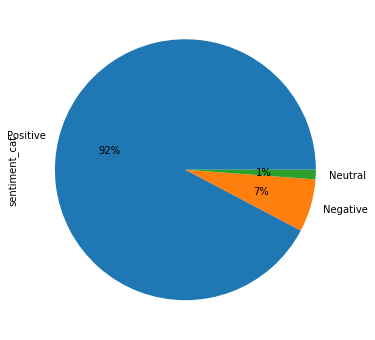

In [45]:
plt.figure(figsize=(12,6))
df['sentiment_cat'].value_counts().plot(kind='pie', autopct= '%1.0f%%')
plt.show()

In [11]:
df.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

# Creating user defined functions for clean the text and pre-process the data

In [12]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
# Text Cleaning
stop = stopwords.words('english') # English Stop words like was, is ,as etc...
def clean_text(text):
    text = text.lower() # Case Standardisation
    text = re.sub(r'[0-9]+', '', text)                        #Replacing numbers with none
    text="".join([char for char in text if char not in string.punctuation]) # remove punctuation    
    return text
df['clean_review']=df['Reviews'].apply(clean_text)

In [14]:
df.head(2)

,Stars,Reviews,sentiment,sentiment_cat,clean_review
0,5,"Great job, Wyndham Capital! Each person was pr...",0.533333,Positive,great job wyndham capital each person was prof...
1,5,Matthew Richardson is professional and helpful...,0.453333,Positive,matthew richardson is professional and helpful...


In [15]:
# removing White space
def remove_whitespaces(text):
    return " ".join(text.split()) ## This will remove all extra spaces etc.
df['clean_review'] = df['clean_review'].apply(remove_whitespaces) 
df.head(2)

,Stars,Reviews,sentiment,sentiment_cat,clean_review
0,5,"Great job, Wyndham Capital! Each person was pr...",0.533333,Positive,great job wyndham capital each person was prof...
1,5,Matthew Richardson is professional and helpful...,0.453333,Positive,matthew richardson is professional and helpful...


In [16]:
# Tokenzation
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

df['clean_review']=df['clean_review'].apply(lambda x: tokenize(x))

df.head(2)

,Stars,Reviews,sentiment,sentiment_cat,clean_review
0,5,"Great job, Wyndham Capital! Each person was pr...",0.533333,Positive,"[great, job, wyndham, capital, each, person, w..."
1,5,Matthew Richardson is professional and helpful...,0.453333,Positive,"[matthew, richardson, is, professional, and, h..."


In [17]:
# English stopwords
stop = stopwords.words('english')

In [18]:
# removing stopwors
def remove_stopwords(tokenized_list):
    filtered_text=[word for word in tokenized_list if word not in stop]
    return filtered_text
df['clean_review']=df['clean_review'].apply(lambda x:remove_stopwords(x))
df.head(2)

,Stars,Reviews,sentiment,sentiment_cat,clean_review
0,5,"Great job, Wyndham Capital! Each person was pr...",0.533333,Positive,"[great, job, wyndham, capital, person, profess..."
1,5,Matthew Richardson is professional and helpful...,0.453333,Positive,"[matthew, richardson, professional, helpful, h..."


In [19]:
# lemmatization
import nltk
wn=nltk.stem.WordNetLemmatizer()

def lemmatizing(text):
    lemma=[wn.lemmatize(word) for word in text]
    return lemma
df['clean_review']=df['clean_review'].apply(lambda x:lemmatizing(x))
df.head(2)

,Stars,Reviews,sentiment,sentiment_cat,clean_review
0,5,"Great job, Wyndham Capital! Each person was pr...",0.533333,Positive,"[great, job, wyndham, capital, person, profess..."
1,5,Matthew Richardson is professional and helpful...,0.453333,Positive,"[matthew, richardson, professional, helpful, h..."


## Count Most Frequent words

In [20]:

word_count={}

for sentence in df['clean_review']:
    for word in sentence:
        
        if word not in word_count:
            word_count[word]=1
            
        else:
            word_count[word]+=1  

In [21]:
## Converting word_count into the dataframe

df1=pd.DataFrame(word_count.items(), columns=['word','word_count'])
df1=df1.sort_values('word_count', ascending=False).reset_index(drop=True)
df1.head()

,word,word_count
0,xd,716
1,loan,326
2,process,248
3,would,246
4,time,217


In [22]:
df.head()

,Stars,Reviews,sentiment,sentiment_cat,clean_review
0,5,"Great job, Wyndham Capital! Each person was pr...",0.533333,Positive,"[great, job, wyndham, capital, person, profess..."
1,5,Matthew Richardson is professional and helpful...,0.453333,Positive,"[matthew, richardson, professional, helpful, h..."
2,5,We had a past experience with Wyndham Mortgage...,-0.033231,Negative,"[past, experience, wyndham, mortgage, would, w..."
3,5,We have been dealing with Brad Thomka from the...,0.093740,Positive,"[dealing, brad, thomka, beginning, started, st..."
4,5,I can't express how grateful I am for the supp...,0.125000,Positive,"[cant, express, grateful, support, zach, provi..."


In [23]:
df['clean_review'] =  df['clean_review'].astype(str) 

# Vectorization (TF_IDF)

In [24]:
vectorizer=TfidfVectorizer(stop_words='english')
X=vectorizer.fit_transform(df['clean_review']).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
# converting array to Data Frame
TF_IDF = pd.DataFrame(X, columns=vectorizer.get_feature_names() )
TF_IDF.head()

,aaron,ability,able,absoltely,absolute,absolutely,accept,acceptable,accepted,access,...,xxxd,year,yelp,yep,yes,youi,youxd,zach,zelada,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.554575,0.0,0.0


In [26]:
word_freq = pd.DataFrame(TF_IDF.apply(sum).head(20), columns=['freq'])
word_freq.sort_values('freq', ascending=False, inplace=True)

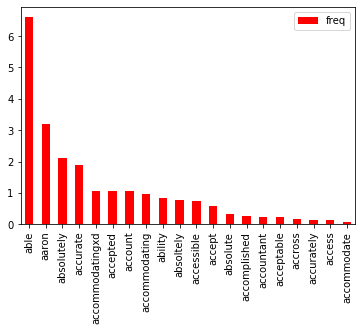

In [27]:
word_freq.plot(kind='bar', color='red')
plt.show()

## WORDCLOUD

In [28]:
word_freq_dictionary = dict(TF_IDF.apply(sum))

In [29]:
wordcloud = WordCloud(background_color='white', stopwords=stop)

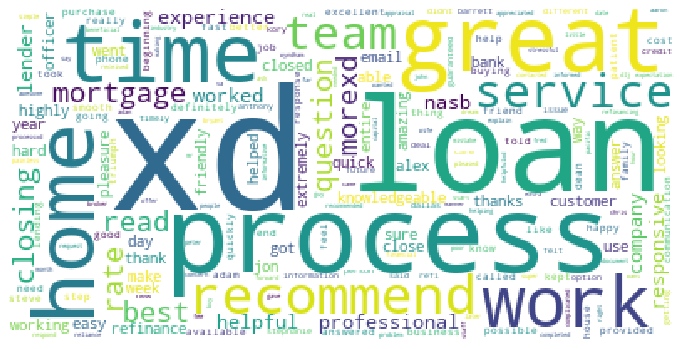

In [30]:
wordcloud = wordcloud.generate_from_frequencies(word_freq_dictionary)

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

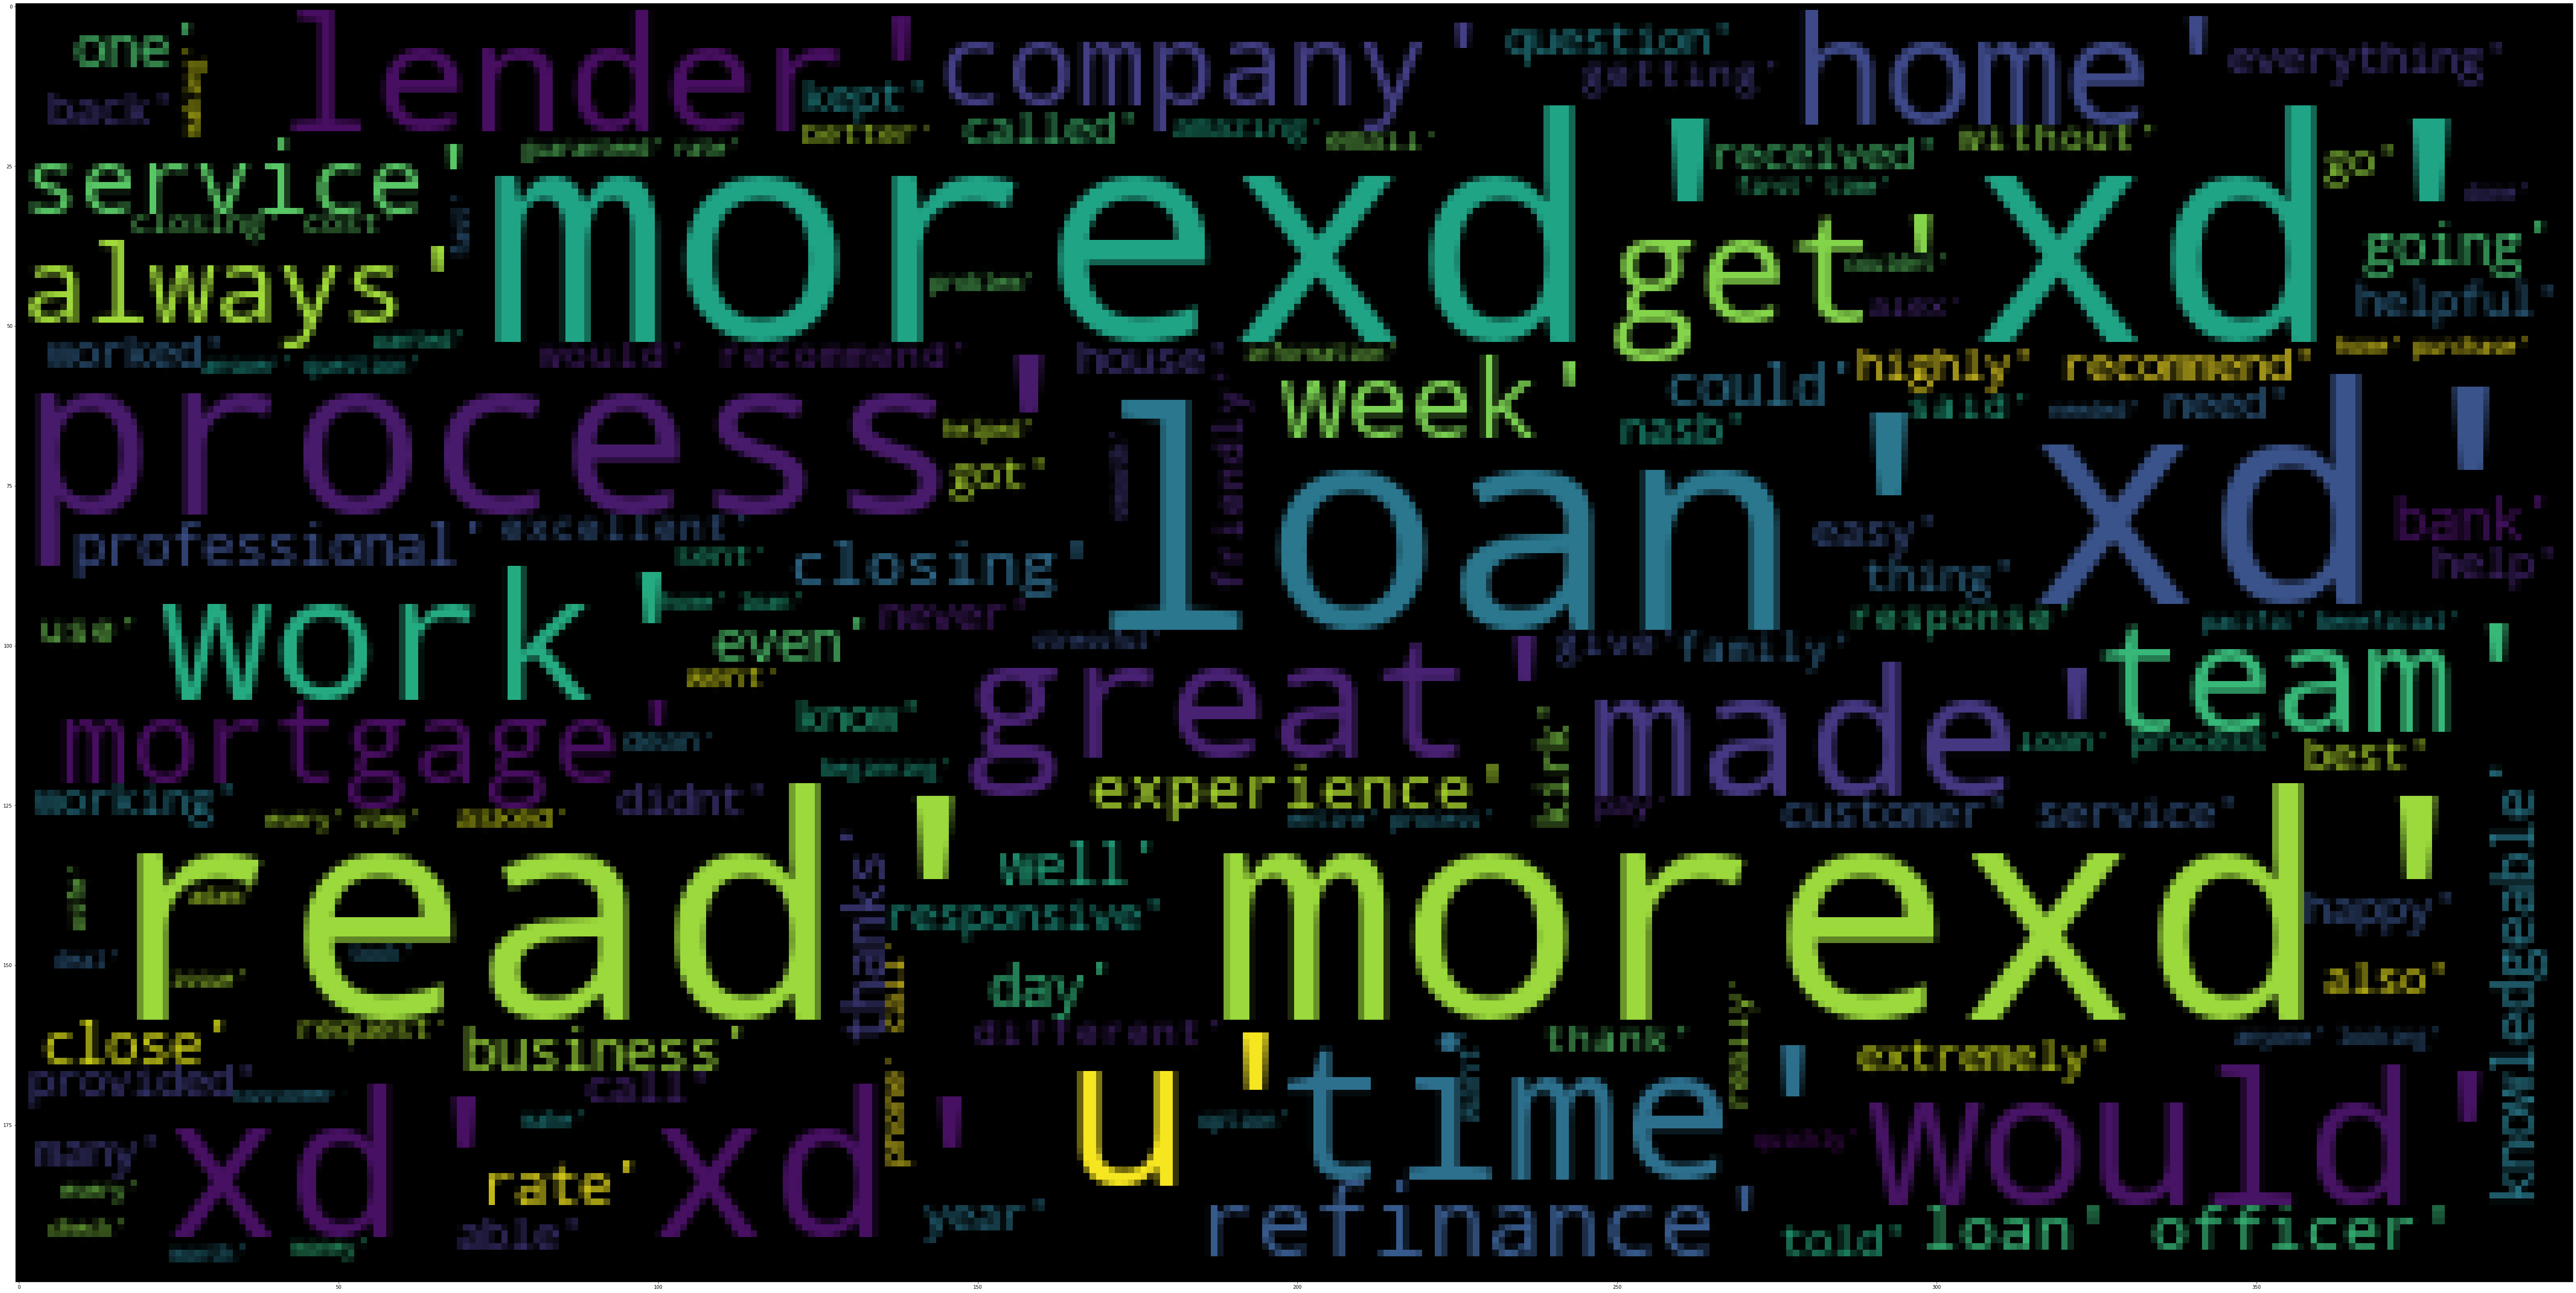

In [31]:
### Generate wordcloud based on words
wordcloud = WordCloud(stopwords=[]).generate(' '.join(df['clean_review'].tolist()))

%matplotlib inline
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)

# Predicting Star Rating

### Split the data into train and test

In [32]:

# define X and y
X = df.clean_review
y = df.Stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(378,)
(127,)
(378,)
(127,)


## Vectorization TF-IDF for both train & test

In [33]:
#train

tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)
X_train_tfidf = tfidf_vect.fit_transform(X_train)

#test
X_test_tfidf = tfidf_vect.transform(X_test)

In [34]:
# coverting to DataFrame
TF_IDF2=pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
TF_IDF2.head()

,aaron,able,absolutely,accept,account,accurate,across,actual,adam,additional,...,worked,working,would,wouldnt,writing,wrong,wyndham,xd,year,yet
0,0.0,0.0,0.0,0.130353,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.121039,0.0,0.0,0.0,0.028797,0.089860,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.090356,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.193803,0.0,0.000000,0.0,0.0,0.0,0.138442,0.000000,0.0
3,0.0,0.0,0.0,0.128180,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.119021,0.0,0.0,0.0,0.000000,0.088362,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.31395,0.000000,0.0,0.000000,0.0,0.0,0.0,0.121049,0.000000,0.0


# Applying Logistic Regression

In [35]:
# fitting the model
log=LogisticRegression()
log.fit(X_train_tfidf,y_train)

LogisticRegression()

In [36]:
 # getting the accuracy

train_accuracy=metrics.accuracy_score(y_train, log.predict(X_train_tfidf))
test_accuracy=metrics.accuracy_score(y_test, log.predict(X_test_tfidf))

print("train_accuracy:", train_accuracy)
print("test_accuracy:", test_accuracy)

train_accuracy: 0.9126984126984127
test_accuracy: 0.8661417322834646


In [37]:
# getting roc_auc_score
train_roc_auc = metrics.roc_auc_score(y_train, log.predict(X_train_tfidf))
print('Roc Auc Score of training dataset: ', train_roc_auc)

test_roc_auc = metrics.roc_auc_score(y_test, log.predict(X_test_tfidf))
print('Roc Auc Score of testing dataset: ', test_roc_auc)

Roc Auc Score of training dataset:  0.7698051948051948
Roc Auc Score of testing dataset:  0.6599999999999999


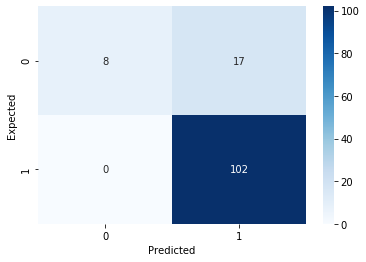

In [38]:
cnf_matrix = confusion_matrix(y_test, log.predict(X_test_tfidf))
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Identifying Key Themes

### Appling Segmentation (Kmean Clustering)

In [39]:
# going for 6 cluster solution
model = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1,random_state=5)
res = model.fit(X_train_tfidf)
res

KMeans(max_iter=100, n_clusters=6, n_init=1, random_state=5)

In [40]:
## getting the centroids and features
centroids= model.cluster_centers_.argsort()[:, ::-1]
features=vectorizer.get_feature_names()

In [41]:
for i in range(0,6):
    print('\n\nCluster %d:' % i)
    for ind in centroids[i, :10]:
        print('\t  - %s' % features[ind])



Cluster 0:
	  - deficiency
	  - current
	  - come
	  - buyingrefinancing
	  - brokerage
	  - began
	  - correctly
	  - brian
	  - corner
	  - bos


Cluster 1:
	  - buyingrefinancing
	  - annoying
	  - deficiency
	  - dedicated
	  - comp
	  - bbb
	  - business
	  - dealt
	  - anticipated
	  - couple


Cluster 2:
	  - category
	  - aggravating
	  - aug
	  - accommodatingxd
	  - avoid
	  - assure
	  - date
	  - biggest
	  - deficiency
	  - alves


Cluster 3:
	  - deficiency
	  - competence
	  - buyingrefinancing
	  - btw
	  - bidding
	  - communicationxd
	  - closingxd
	  - based
	  - biggest
	  - dedicated


Cluster 4:
	  - deficiency
	  - accurate
	  - decision
	  - closingxd
	  - accommodatingxd
	  - current
	  - asked
	  - began
	  - debit
	  - attention


Cluster 5:
	  - deficiency
	  - congratulation
	  - began
	  - complicated
	  - corner
	  - bestxd
	  - closingxd
	  - decision
	  - assisted
	  - comp


In [42]:
pred_stars = pd.DataFrame(log.predict(X_train_tfidf), columns = ['predicted_stars'])
final = pd.concat([df, pred_stars], axis=1)
final.head()

,Stars,Reviews,sentiment,sentiment_cat,clean_review,predicted_stars
0,5,"Great job, Wyndham Capital! Each person was pr...",0.533333,Positive,"['great', 'job', 'wyndham', 'capital', 'person...",1.0
1,5,Matthew Richardson is professional and helpful...,0.453333,Positive,"['matthew', 'richardson', 'professional', 'hel...",5.0
2,5,We had a past experience with Wyndham Mortgage...,-0.033231,Negative,"['past', 'experience', 'wyndham', 'mortgage', ...",5.0
3,5,We have been dealing with Brad Thomka from the...,0.093740,Positive,"['dealing', 'brad', 'thomka', 'beginning', 'st...",1.0
4,5,I can't express how grateful I am for the supp...,0.125000,Positive,"['cant', 'express', 'grateful', 'support', 'za...",5.0
